# CMF within dimensions of public acceptability

Coupled matrix factorisation (CMF) can be used to perform topic modeling on two corpora at the same time. Now it's time to compare media articles and parliamentary speeches to discover latent topics within each dimension of public acceptability.

In this notebook, I will:
- Train a single Word2Vec model
- Measure similarity between documents and the four dimensions
- Identify the most relevant parliamentary speeches and media articles for each dimension
- Compare the two corpora in each of the four dimensions

In [1]:
import pandas as pd
import gensim
import numpy as np

import spacy
nlp = spacy.load("fr_core_news_sm")
from spacy.lang.fr.stop_words import STOP_WORDS
import string 

from scipy import spatial

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import matcouply.decomposition as decomposition
from matcouply.coupled_matrices import CoupledMatrixFactorization

2024-02-28 10:45:55.460319: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 10:45:56.656745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 10:45:56.656852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 10:45:56.852243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 10:45:57.315479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

## Data prep

### Parliament

In [2]:
# Import data from session on retraite and speeches mentioning retraite
df_title_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_title_retraite.csv')
df_speech_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_speech_retraite.csv')

# Merge data from session on retraite and speeches mentioning retraite
df_parl = pd.concat([df_title_retraite, df_speech_retraite])
df_parl = df_parl.dropna(subset='speech').drop_duplicates(subset='speech')

# Filter speeches from November 2022 onwards
df_parl['dateSeance'] = pd.to_datetime(df_parl['dateSeance'], format='%Y%m%d%H%M%S%f')
df_parl = df_parl[df_parl['dateSeance'] >= pd.to_datetime('2022-11-01')]
df_parl.shape

(1395, 15)

In [358]:
df_parl.columns

Index(['rapporteur_nom', 'rapporteur_id', 'speech', 'seanceRef', 'sessionRef',
       'dateSeance', 'numSeanceJour', 'numSeance', 'typeAssemblee',
       'legislature', 'session', 'nomFichierJo', 'presidentSeance', 'intitule',
       'sousIntitule', 'TextLemmatized', 'TextProcessed'],
      dtype='object')

In [3]:
# Preprocess data
stopwords = set(STOP_WORDS)
custom_sw_parl = {'réforme','retraite','retrait','oui','no','avis','mme','monsieur','parole','pouvoir','faire','devoir','bien',
                  'falloir','prendre','aller','bon','vouloir','bien','favorable','sous','remettre'}
stopwords.update(custom_sw_parl)

def lemmatizer(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

def whitespace_remover(tokens):
    filtered_tokens = [token for token in tokens if token.strip() != '']
    filtered_tokens_newline = [token for token in filtered_tokens if token != '\n\n']
    return filtered_tokens_newline
    
def sw_remover(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

def punct_remover(tokens):
    filtered_tokens = [token for token in tokens if not any(char in string.punctuation for char in token)] # I changed from all to any!!
    return filtered_tokens

def lowercaser(tokens):
    filtered_tokens = [token.lower() for token in tokens]
    return filtered_tokens

def joiner(tokens):
    joined_tokens = ' '.join(tokens)
    return joined_tokens

In [4]:
# Create a new column 'TextLemmatized'
df_parl['TextLemmatized'] = df_parl['speech'].progress_apply(lemmatizer)
df_parl['TextProcessed'] = df_parl['TextLemmatized'].progress_apply(whitespace_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(sw_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(punct_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(lowercaser)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(joiner)

df_parl['TextProcessed']

100%|███████████████████████████████████| 1395/1395 [00:00<00:00, 184663.22it/s]


0       chose souhaiter rappeler solennellemer groupe ...
1       cadre semaine contrôle gouvernement groupe lfi...
2                        quell beau cravate rouge sourire
3       préambule aimerai prévenir amalgame rappeler p...
4       celer mois mouvement social opposer propos sal...
                              ...                        
1394    regretter oziol répondre réalité répondre poin...
1395    actuellement mettre contribution plateforme ac...
1396    matin subir tunnel interminable amendement ide...
1397    france insoumis mémoire court occasion crise s...
1398    triste spectacle cher collègue danièle obono e...
Name: TextProcessed, Length: 1395, dtype: object

### Media

In [5]:
# Import data
df_selectedmedia = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/GDELT_221001_selectedmedia_Dec23.csv')
df_selectedmedia['DATE'] = pd.to_datetime(df_selectedmedia['DATE'])
df_selectedmedia['TextProcessed'] = df_selectedmedia['TextProcessed'].str.lower()
df_selectedmedia.shape

(10141, 12)

In [357]:
df_selectedmedia.SourceCommonName.unique()

array(['leparisien.fr', 'liberation.fr', 'lequipe.fr', 'lemonde.fr',
       'lepoint.fr', 'humanite.fr', 'lefigaro.fr', 'lesechos.fr',
       'la-croix.com', 'latribune.fr'], dtype=object)

### Merge

In [6]:
df_parl_text = df_parl[['dateSeance','TextProcessed','speech']]
df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
df_parl_text['Source'] = 'Parliament'

/tmp/ipykernel_992462/517243120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
/tmp/ipykernel_992462/517243120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text['Source'] = 'Parliament'


In [7]:
df_selectedmedia_text = df_selectedmedia[['DATE','TextProcessed','Text']]
df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
df_selectedmedia_text['Source'] = 'Media'

/tmp/ipykernel_992462/4282530041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
/tmp/ipykernel_992462/4282530041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text['Source'] = 'Media'


In [8]:
df_merge = pd.concat([df_parl_text, df_selectedmedia_text])
df_merge

,Date,TextProcessed,Text,Source
0,2023-05-03 15:00:00,chose souhaiter rappeler solennellemer groupe ...,"Avant toute chose, je souhaite rappeler solenn...",Parliament
1,2023-05-03 15:00:00,cadre semaine contrôle gouvernement groupe lfi...,Dans le cadre de la semaine de contrôle du Gou...,Parliament
2,2023-05-03 15:00:00,quell beau cravate rouge sourire,Quelle belle cravate rouge ! (Sourires.),Parliament
3,2023-05-03 15:00:00,préambule aimerai prévenir amalgame rappeler p...,"En préambule, j’aimerais, pour prévenir tout a...",Parliament
4,2023-05-03 15:00:00,celer mois mouvement social opposer propos sal...,Cela fait quatre mois qu’un mouvement social s...,Parliament
...,...,...,...,...
10136,2023-01-03 11:00:00,annonce douche froid partenaire social apprend...,L'annonce avait fait l'effet d'une douche froi...,Media
10137,2023-01-03 18:00:00,immobilier ancien retrouver phase atterrissage...,Le marché de l'immobilier ancien va retrouver ...,Media
10138,2023-03-18 15:45:00,paris reuters affrontement police lieu paris s...,PARIS (Reuters) - Des affrontements avec la po...,Media
10139,2023-03-20 11:45:00,elizabeth pineau paris reuters gouvernement el...,par Elizabeth Pineau\n\nPARIS (Reuters) - Le g...,Media


In [488]:
df_merge = df_merge[~df_merge['TextProcessed'].str.contains('orpea')]
df_merge

,Date,TextProcessed,Text,Source
0,2023-05-03 15:00:00,chose souhaiter rappeler solennellemer groupe ...,"Avant toute chose, je souhaite rappeler solenn...",Parliament
1,2023-05-03 15:00:00,cadre semaine contrôle gouvernement groupe lfi...,Dans le cadre de la semaine de contrôle du Gou...,Parliament
2,2023-05-03 15:00:00,quell beau cravate rouge sourire,Quelle belle cravate rouge ! (Sourires.),Parliament
3,2023-05-03 15:00:00,préambule aimerai prévenir amalgame rappeler p...,"En préambule, j’aimerais, pour prévenir tout a...",Parliament
4,2023-05-03 15:00:00,celer mois mouvement social opposer propos sal...,Cela fait quatre mois qu’un mouvement social s...,Parliament
...,...,...,...,...
10136,2023-01-03 11:00:00,annonce douche froid partenaire social apprend...,L'annonce avait fait l'effet d'une douche froi...,Media
10137,2023-01-03 18:00:00,immobilier ancien retrouver phase atterrissage...,Le marché de l'immobilier ancien va retrouver ...,Media
10138,2023-03-18 15:45:00,paris reuters affrontement police lieu paris s...,PARIS (Reuters) - Des affrontements avec la po...,Media
10139,2023-03-20 11:45:00,elizabeth pineau paris reuters gouvernement el...,par Elizabeth Pineau\n\nPARIS (Reuters) - Le g...,Media


## Word2Vec

In [489]:
documents = df_merge['Text'].astype(str).to_list()

documents_processed = df_merge['TextProcessed']
documents_processed = documents_processed.astype(str).to_list()

documents_tokenised = []
for doc in documents_processed:
  tokens = doc.split()
  documents_tokenised.append(tokens)

len(documents_tokenised)

11449

In [490]:
# Training Word2Vec model from the merged documents
model = gensim.models.Word2Vec(documents_tokenised, vector_size=100, window=5, min_count=1, workers=4)

### Doc-keywords similarity

In [491]:
document_centroids_in = []

for doc in documents_tokenised:

  document_vecs = []
  
  for word in doc:
    if word in model.wv:
      word_vec = model.wv[word]
      document_vecs.append(word_vec)
      
  if document_vecs: # I had to add this here because I obtained warning indicating there are some empty speech_vecs lists resulted in NaN when mean
      document_centroid = np.mean(document_vecs, axis=0)
      
  document_centroids_in.append(document_centroid)

In [492]:
def keyword_sim(keywords, doc_vecs):
  
  doc_scores = []
  
  for doc_vec in doc_vecs:

    keyword_sims = []

    for keyword in keywords:
      if keyword in model.wv:      
        sim = 1 - spatial.distance.cosine(model.wv[keyword], doc_vec)  
        keyword_sims.append(sim)

    doc_score = sum(keyword_sims) / len(keyword_sims)
    doc_scores.append(doc_score)

  return doc_scores

In [493]:
kws_econ_extended = ['compte public', 'finance', 'investissement', 'croissance', 'création emploi', 'compétitivité', 'soutenabilité', 'financement', 'pérennité', 'chômage', 'emploi', 'pib', 'prix', 'coût transition', 'incitation', 'espérance vie', 'départ anticipé', 'euro', 'contribution', 'productivité', 'dette', 'déficit', 'achat', 'démographique', 'attractivité', 'inflation', 'naissance', 'population', 'prime', 'travailleur', 'valeur', 'public', 'entreprise', 'banque', 'crise', 'cdc', 'industriel', 'territoire', 'fiscal', 'insee', 'revenu', 'cotisation', 'niveau', '62', 'argent', 'agriculture', 'industrie', 'totalenergie', 'cor', '64', 'actif', 'patrimoine', 'milliard', 'taux', 'cadre', 'travail', 'budget', 'direction', 'caisse', 'million', 'capital', 'salaire', 'pension', 'paiement', 'cotiser', 'facture', 'point', 'bourse', 'consommation', 'travailler', 'immobilier']
kws_fair_extended = ['gagnant', 'perdant', 'justice', 'morale', 'inégalité', 'riche', 'pauvre', 'pénibilité', 'carrière long', 'solidarité', 'décent', 'bonne santé', 'régime spécial', 'régime complémentaire', 'Agirc-Arrco', 'redistributif', 'femme', 'cotisation', 'équité', 'égalité', 'discrimination', 'privilège', 'richesse', 'classe sociale', 'précarité', '65', 'prime', 'fonctionnaire', 'public', 'mari', 'police', 'sncf', 'mixte', 'cheminots', 'niveau', 'edf', 'agriculture', 'industrie', 'ratp', 'fraude', 'jeunesse', 'totalenergie', 'usine', '64', 'marier', 'milliardaire', 'minimal', 'jeune', 'patrimoine', 'index', 'policier', 'taux', 'couple', 'cadre', 'plafond', 'homme', 'ouvrier', 'partage', 'social', 'capital', 'fortune', 'enseignant', 'smic', 'senior', 'agriculteur']
kws_risktime_extended = ['assurance', 'génération futur', 'génération', 'enfant', 'protection', 'mutualisation', 'myopie', 'déséquilibre', 'compréhension', 'ajustement automatique', 'ajustement', 'décote', 'bonus', 'malus', 'long terme', 'court terme', 'durabilité', 'vulnérabilité', 'incertitude', 'volatilité', 'futur', 'sécurité', 'aléas', 'imprévisibilité', 'imprévisible', 'scénario', 'jeune', 'climat', 'dette', '65', 'crise', 'cdc', 'vie', 'climatique', 'carbone', 'jeunesse', 'cor', 'soin', 'plan', 'index', 'temps', 'population', 'enfance', 'trimestre', 'naissance', 'ehpad']
kws_proc_extended = ['processus législatif', 'processus', 'vote', 'consultation', 'dialogue social', 'partenaire social', 'grève', 'manifestation', 'communication', 'confiance', 'polarisation', 'démocratie', '49', 'COR', 'période transition', 'motion censure', 'transparence', 'négociation', 'consensus', 'référendum', 'compromis', 'mobilisation', 'syndicat', 'liot', 'peuple', 'amendement', 'anti', 'populaire', 'crise', 'report', 'cgt', 'commission', 'police', 'intersyndicale', 'gauche', 'article', 'loi', 'leader', 'pause', 'examen', 'martinez', 'manifestant', 'motion', 'texte', 'dussopt', 'macron', 'projet', 'bloquer', 'borne', 'initiative', 'proposition', 'gouvernement', 'nupes', 'grenade', 'policier', 'censure', 'droit', 'rn', 'syndical', 'berger', 'obstruction', 'presse', 'mouvement', 'medef', 'crs', 'constitutionnel', 'lr', 'droite', 'force', 'ordre', 'bardella', 'accord', 'cnr', 'groupe', 'communiste', 'etat', 'riester', 'garde', 'rip', 'politique', 'dysfonctionnement', 'voter', 'journaliste', 'cfdt', 'revendication', 'retrait', 'juge', 'tribunal', 'maire', 'vert', 'violence']

economy_sims_inin = keyword_sim(kws_econ_extended, document_centroids_in)
fairness_sims_inin = keyword_sim(kws_fair_extended, document_centroids_in)
risktime_sims_inin = keyword_sim(kws_risktime_extended, document_centroids_in)
process_sims_inin = keyword_sim(kws_proc_extended, document_centroids_in)

In [494]:
sim_df = pd.DataFrame()

sim_df['economy_sim_inin'] = economy_sims_inin
sim_df['fairness_sim_inin'] = fairness_sims_inin
sim_df['risktime_sim_inin'] = risktime_sims_inin
sim_df['process_sim_inin'] = process_sims_inin

sim_df['article'] = documents
sim_df['article_processed'] = documents_processed
sim_df['Date'] = df_merge['Date'].values
sim_df['Source'] = df_merge['Source'].values

sim_df

,economy_sim_inin,fairness_sim_inin,risktime_sim_inin,process_sim_inin,article,article_processed,Date,Source
0,0.274799,0.347872,0.365362,0.419369,"Avant toute chose, je souhaite rappeler solenn...",chose souhaiter rappeler solennellemer groupe ...,2023-05-03 15:00:00,Parliament
1,0.234843,0.274707,0.256595,0.406931,Dans le cadre de la semaine de contrôle du Gou...,cadre semaine contrôle gouvernement groupe lfi...,2023-05-03 15:00:00,Parliament
2,0.060915,0.175657,0.165805,0.179201,Quelle belle cravate rouge ! (Sourires.),quell beau cravate rouge sourire,2023-05-03 15:00:00,Parliament
3,0.228434,0.300095,0.309263,0.436496,"En préambule, j’aimerais, pour prévenir tout a...",préambule aimerai prévenir amalgame rappeler p...,2023-05-03 15:00:00,Parliament
4,0.293204,0.338404,0.339091,0.412891,Cela fait quatre mois qu’un mouvement social s...,celer mois mouvement social opposer propos sal...,2023-05-03 15:00:00,Parliament
...,...,...,...,...,...,...,...,...
11444,0.369781,0.337870,0.352992,0.372030,L'annonce avait fait l'effet d'une douche froi...,annonce douche froid partenaire social apprend...,2023-01-03 11:00:00,Media
11445,0.499865,0.430228,0.500700,0.287287,Le marché de l'immobilier ancien va retrouver ...,immobilier ancien retrouver phase atterrissage...,2023-01-03 18:00:00,Media
11446,0.139425,0.197398,0.173614,0.371686,PARIS (Reuters) - Des affrontements avec la po...,paris reuters affrontement police lieu paris s...,2023-03-18 15:45:00,Media
11447,0.194529,0.237767,0.232751,0.456742,par Elizabeth Pineau\n\nPARIS (Reuters) - Le g...,elizabeth pineau paris reuters gouvernement el...,2023-03-20 11:45:00,Media


### Keyword count

In [495]:
def count_keywords(article, keywords):
  keyword_set = set(keywords)
  found_words = set()
  count = 0

  for word in article.split():
    if word in keyword_set:
      if word not in found_words:
        count += 1
        found_words.add(word)

  return count

In [496]:
sim_df['econ_count'] = 0
sim_df['fair_count'] = 0
sim_df['risktime_count'] = 0
sim_df['proc_count'] = 0

for index, row in sim_df.iterrows():
    sim_df.loc[index,'econ_count'] = count_keywords(row['article_processed'], kws_econ_extended)
    sim_df.loc[index,'fair_count'] = count_keywords(row['article_processed'], kws_fair_extended)
    sim_df.loc[index,'risktime_count'] = count_keywords(row['article_processed'], kws_risktime_extended)
    sim_df.loc[index,'proc_count'] = count_keywords(row['article_processed'], kws_proc_extended)

### Cutting the corpora

In [497]:
sim_df_media = sim_df[sim_df['Source'] == 'Media']
sim_df_parl = sim_df[sim_df['Source'] == 'Parliament']
print(f'The shape of `sim_df_media` is {sim_df_media.shape} and the shape of `sim_df_parl is {sim_df_parl.shape}`')

The shape of `sim_df_media` is (10057, 12) and the shape of `sim_df_parl is (1392, 12)`


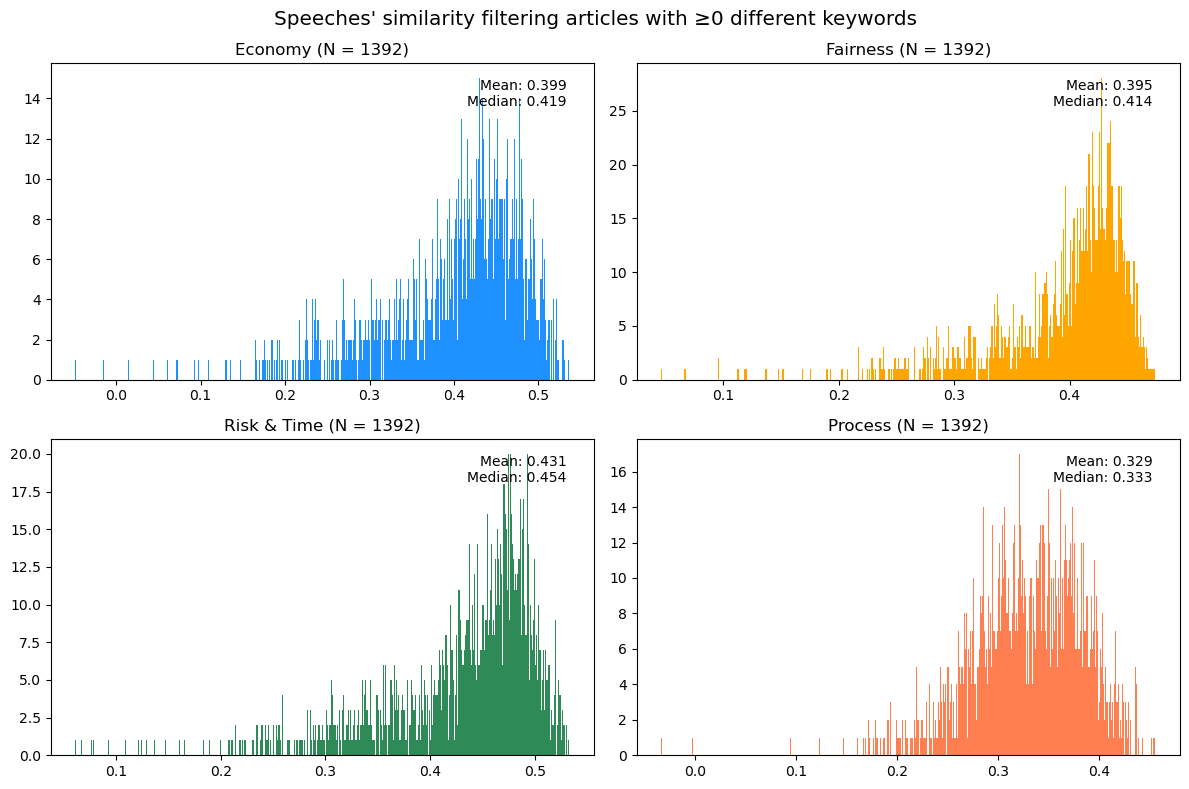

In [498]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_parl[sim_df_parl['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_parl[sim_df_parl['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_parl[sim_df_parl['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_parl[sim_df_parl['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_inin'], bins=np.arange(min(sim_df_economy['economy_sim_inin']), max(sim_df_economy['economy_sim_inin']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_inin'], bins=np.arange(min(sim_df_fairness['fairness_sim_inin']), max(sim_df_fairness['fairness_sim_inin']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_inin'], bins=np.arange(min(sim_df_risktime['risktime_sim_inin']), max(sim_df_risktime['risktime_sim_inin']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_inin'], bins=np.arange(min(sim_df_process['process_sim_inin']), max(sim_df_process['process_sim_inin']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_inin'])
economy_median = np.median(sim_df_economy['economy_sim_inin'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_inin'])
fairness_median = np.median(sim_df_fairness['fairness_sim_inin'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_inin'])
risktime_median = np.median(sim_df_risktime['risktime_sim_inin'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_inin'])
process_median = np.median(sim_df_process['process_sim_inin'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Speeches' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

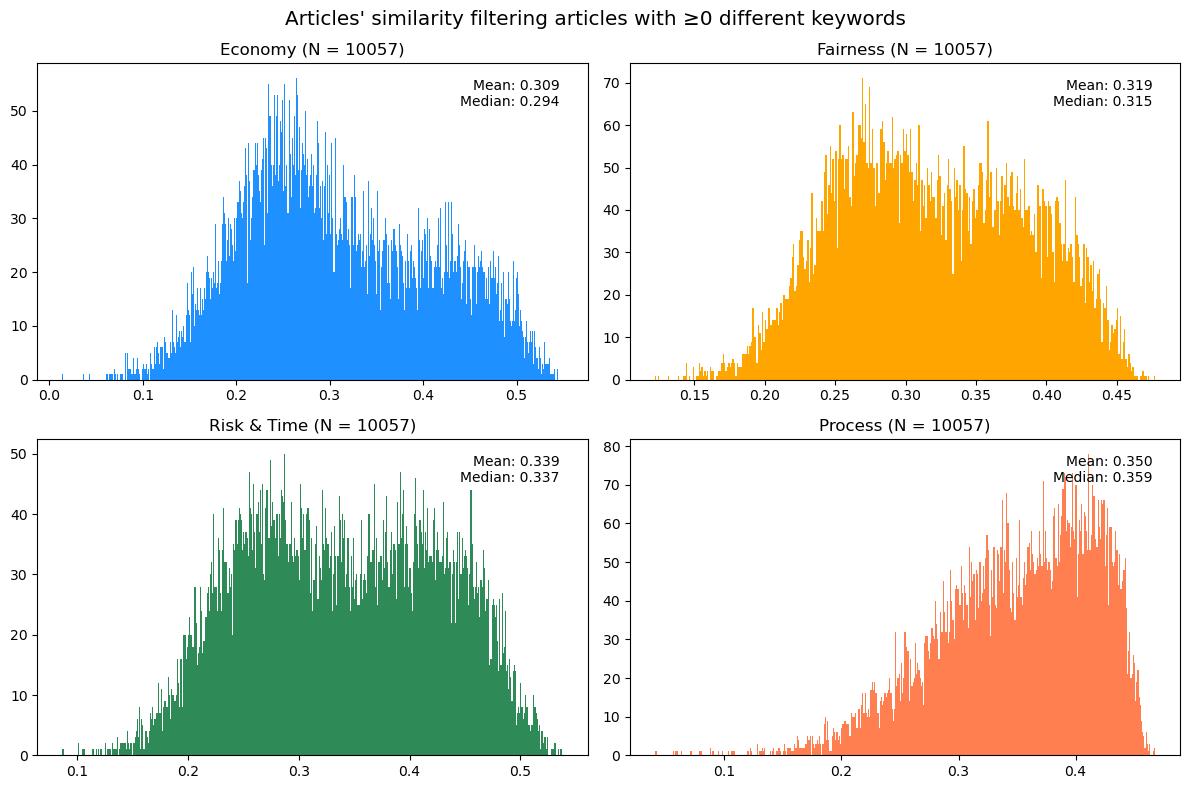

In [499]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_media[sim_df_media['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_media[sim_df_media['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_media[sim_df_media['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_media[sim_df_media['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_inin'], bins=np.arange(min(sim_df_economy['economy_sim_inin']), max(sim_df_economy['economy_sim_inin']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_inin'], bins=np.arange(min(sim_df_fairness['fairness_sim_inin']), max(sim_df_fairness['fairness_sim_inin']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_inin'], bins=np.arange(min(sim_df_risktime['risktime_sim_inin']), max(sim_df_risktime['risktime_sim_inin']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_inin'], bins=np.arange(min(sim_df_process['process_sim_inin']), max(sim_df_process['process_sim_inin']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_inin'])
economy_median = np.median(sim_df_economy['economy_sim_inin'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_inin'])
fairness_median = np.median(sim_df_fairness['fairness_sim_inin'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_inin'])
risktime_median = np.median(sim_df_risktime['risktime_sim_inin'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_inin'])
process_median = np.median(sim_df_process['process_sim_inin'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Articles' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

In [500]:
# Filter out articles with less than 2 keyword matches and select those ≥50th percentile
filter_threshold = 0
percentage_cut = 0.10

filtered_economy_parl = sim_df_parl[sim_df_parl['econ_count'] >= filter_threshold]
top_economy_parl = filtered_economy_parl.nlargest(int(len(filtered_economy_parl) * percentage_cut), 'economy_sim_inin')

filtered_fairness_parl = sim_df_parl[sim_df_parl['fair_count'] >= filter_threshold]
top_fairness_parl = filtered_fairness_parl.nlargest(int(len(filtered_fairness_parl) * percentage_cut), 'fairness_sim_inin')

filtered_risktime_parl = sim_df_parl[sim_df_parl['risktime_count'] >= filter_threshold]
top_risktime_parl = filtered_risktime_parl.nlargest(int(len(filtered_risktime_parl) * percentage_cut), 'risktime_sim_inin')

filtered_process_parl = sim_df_parl[sim_df_parl['proc_count'] >= filter_threshold]
top_process_parl = filtered_process_parl.nlargest(int(len(filtered_process_parl) * percentage_cut), 'process_sim_inin')

# Prepare the four corpora
corpus_economy_parl = top_economy_parl['article_processed']
corpus_fairness_parl = top_fairness_parl['article_processed']
corpus_risktime_parl = top_risktime_parl['article_processed']
corpus_process_parl = top_process_parl['article_processed']

print('The number of relevant articles for each corpus is:' +
      '\n  -  Economic dimension: ' + str(len(corpus_economy_parl)) +
      '\n  -  Fairness dimension: ' + str(len(corpus_fairness_parl)) +
      '\n  -  Risk & Time dimension: ' + str(len(corpus_risktime_parl)) +
      '\n  -  Process dimension: ' + str(len(corpus_process_parl)))

The number of relevant articles for each corpus is:
  -  Economic dimension: 139
  -  Fairness dimension: 139
  -  Risk & Time dimension: 139
  -  Process dimension: 139


In [501]:
filter_threshold = 0
percentage_cut = 0.05

filtered_economy_media = sim_df_media[sim_df_media['econ_count'] >= filter_threshold]
top_economy_media = filtered_economy_media.nlargest(int(len(filtered_economy_media) * percentage_cut), 'economy_sim_inin')

filtered_fairness_media = sim_df_media[sim_df_media['fair_count'] >= filter_threshold]
top_fairness_media = filtered_fairness_media.nlargest(int(len(filtered_fairness_media) * percentage_cut), 'fairness_sim_inin')

filtered_risktime_media = sim_df_media[sim_df_media['risktime_count'] >= filter_threshold]
top_risktime_media = filtered_risktime_media.nlargest(int(len(filtered_risktime_media) * percentage_cut), 'risktime_sim_inin')

filtered_process_media = sim_df_media[sim_df_media['proc_count'] >= filter_threshold]
top_process_media = filtered_process_media.nlargest(int(len(filtered_process_media) * percentage_cut), 'process_sim_inin')

# Prepare the four corpora
corpus_economy_media = top_economy_media['article_processed']
corpus_fairness_media = top_fairness_media['article_processed']
corpus_risktime_media = top_risktime_media['article_processed']
corpus_process_media = top_process_media['article_processed']

print('The number of relevant articles for each corpus is:' +
      '\n  -  Economic dimension: ' + str(len(corpus_economy_media)) +
      '\n  -  Fairness dimension: ' + str(len(corpus_fairness_media)) +
      '\n  -  Risk & Time dimension: ' + str(len(corpus_risktime_media)) +
      '\n  -  Process dimension: ' + str(len(corpus_process_media)))


The number of relevant articles for each corpus is:
  -  Economic dimension: 502
  -  Fairness dimension: 502
  -  Risk & Time dimension: 502
  -  Process dimension: 502


## Corpus comparison

### Economy

#### Matrices prep

In [607]:
documents = corpus_economy_parl.to_list() + corpus_economy_media.to_list()

In [608]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

num_rows_parl = len(corpus_economy_parl)
num_rows_media = len(corpus_economy_media)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:num_rows_parl, :]
count_matrix_media = count_matrix[-num_rows_media:, :]

In [609]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

#### CMF

In [610]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [611]:
n_components = 10
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

#### Results

In [612]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: banque, 2025, france, suisse, 2024, pourcent, institution, inflation, bancaire, croissance
Topic #2: euro, milliard, million, 2022, groupe, actionnaire, stellantis, action, pourcent, entreprise
Topic #3: recherche, agricole, production, france, agriculture, agriculteur, entreprise, investissement, pays, prix
Topic #4: dette, public, milliard, pib, finance, pourcent, taux, gouvernement, france, recette
Topic #5: cotisation, emploi, social, travail, salaire, an, entreprise, vie, taux, revenu
Topic #6: logement, immobilier, taxe, revenu, foncier, promoteur, 000, location, euro, ville
Topic #7: pourcent, prix, inflation, hausse, consommation, alimentaire, insee, trimestre, produit, 2023
Topic #8: scpi, immobilier, rendement, placement, fonds, investir, livret, argent, meilleur, investissement
Topic #9: pension, capitalisation, fonctionnaire, cotisation, euro, pourcent, minimum, montant, gouvernement, caisse
Topic #10: per, assurance, plan, vie, retraire, rente, revenu, contrat, v

In [613]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [614]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

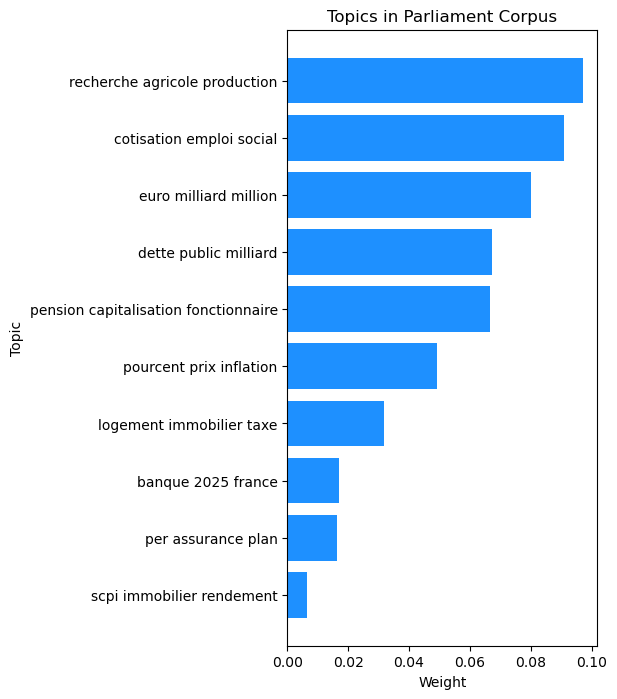

In [615]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

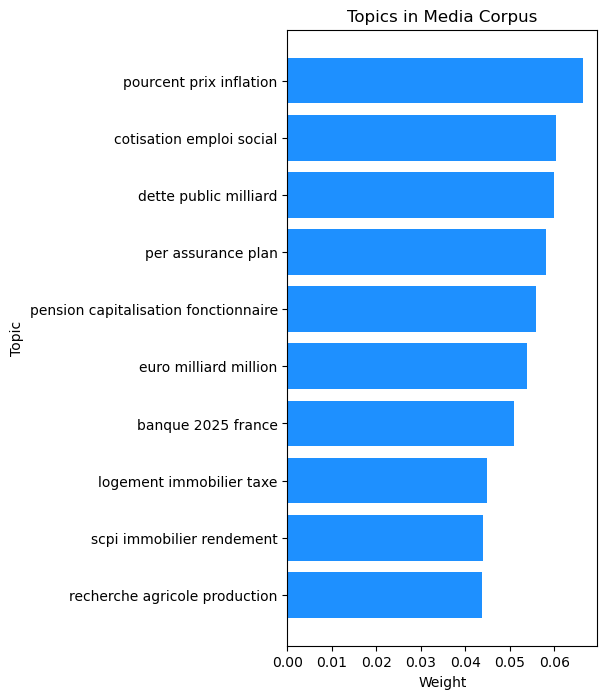

In [616]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

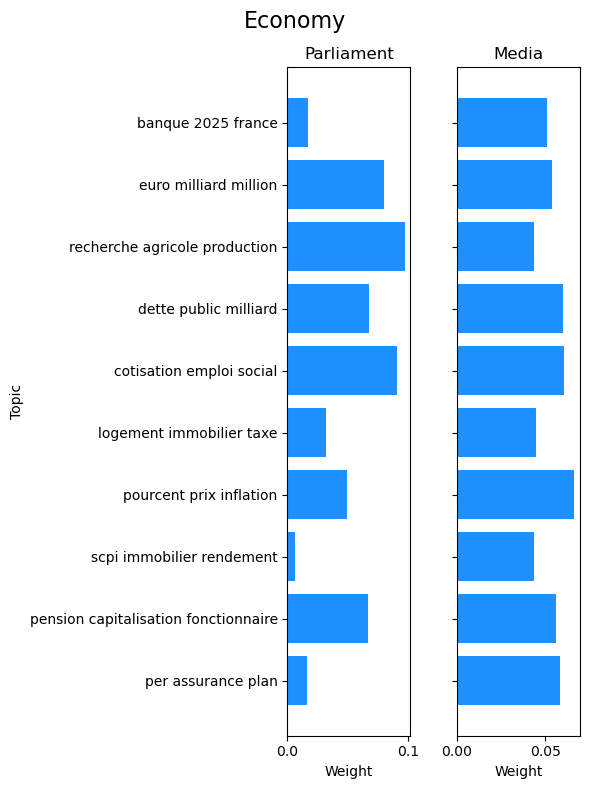

In [617]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Economy', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

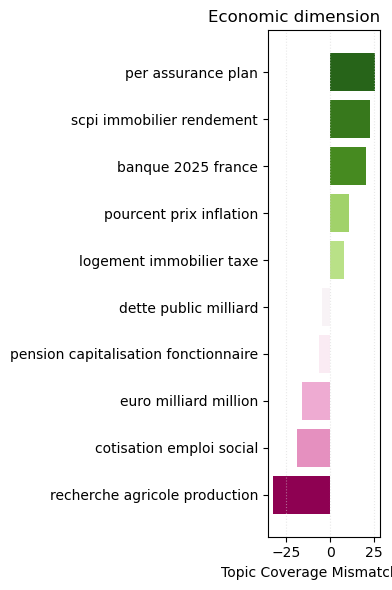

In [619]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Economic dimension', loc='right')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Fairness

#### Matrices prep

In [620]:
documents = corpus_fairness_parl.to_list() + corpus_fairness_media.to_list()

In [621]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

num_rows_parl = len(corpus_economy_parl)
num_rows_media = len(corpus_economy_media)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:num_rows_parl, :]
count_matrix_media = count_matrix[-num_rows_media:, :]

In [622]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

#### CMF

In [632]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [633]:
cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

#### Results

In [634]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: femme, homme, pourcent, enfant, pension, partiel, temps, couple, genre, inégalité
Topic #2: per, assurance, plan, rente, contrat, revenu, fonds, produit, assureur, capital
Topic #3: cotisation, social, entreprise, milliard, salaire, travail, capital, emploi, financier, richesse
Topic #4: enseignant, revalorisation, professeur, enseigner, métier, mission, salaire, recherche, prime, augmentation
Topic #5: pension, cotisation, per, travail, euro, agricole, an, pourcent, emploi, logement
Topic #6: pension, cotisation, capitalisation, pourcent, euro, fonctionnaire, gouvernement, niveau, an, montant
Topic #7: an, travail, emploi, senior, travailler, vie, professionnel, temps, pourcent, partir
Topic #8: agricole, agriculteur, exploitation, terre, agriculture, ferme, hectare, vache, paysan, installation
Topic #9: enseignant, pension, cotisation, travail, agricole, euro, salaire, revalorisation, professeur, emploi
Topic #10: logement, euro, enfant, immobilier, prix, aide, association,

In [635]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [636]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

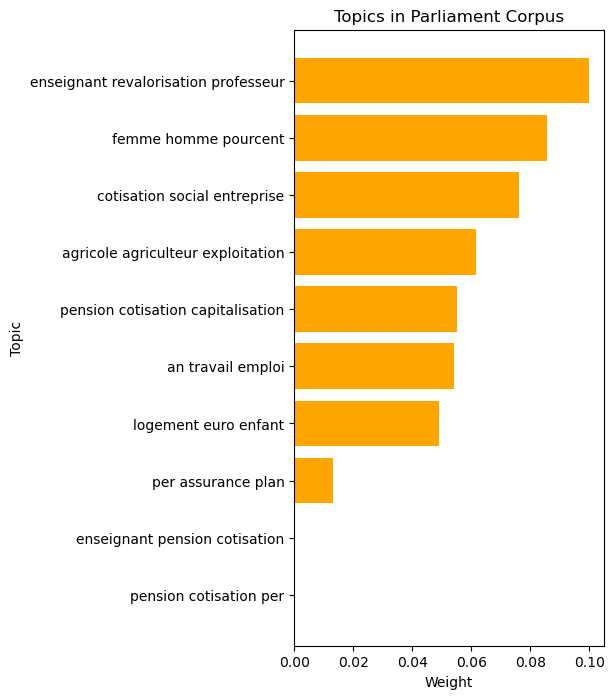

In [637]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='orange')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

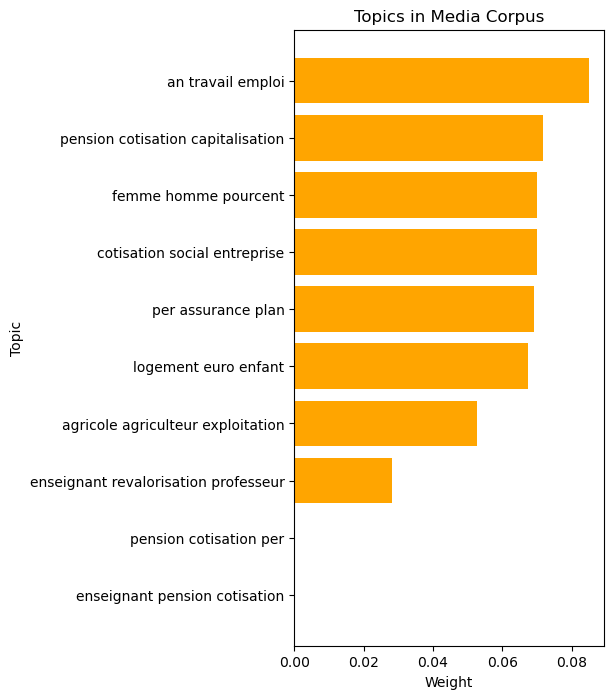

In [638]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='orange')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

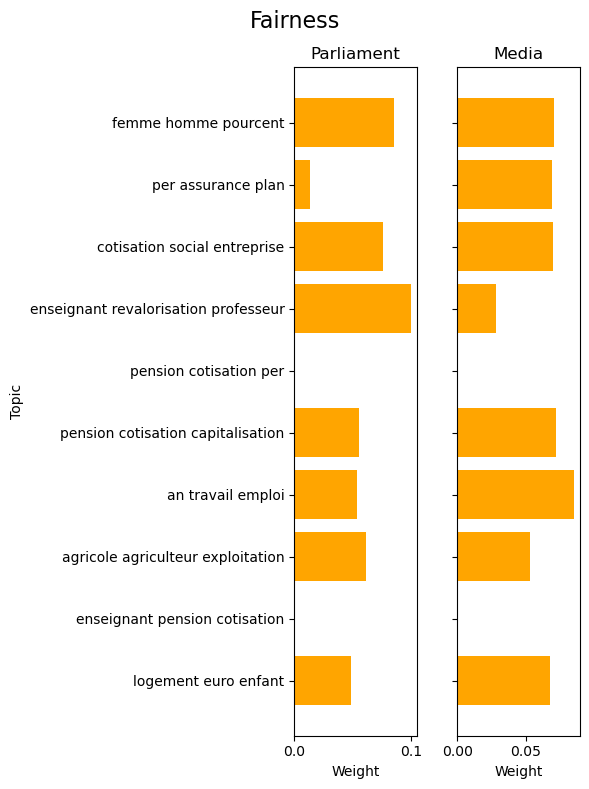

In [639]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='orange')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='orange')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Title
fig.suptitle('Fairness', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

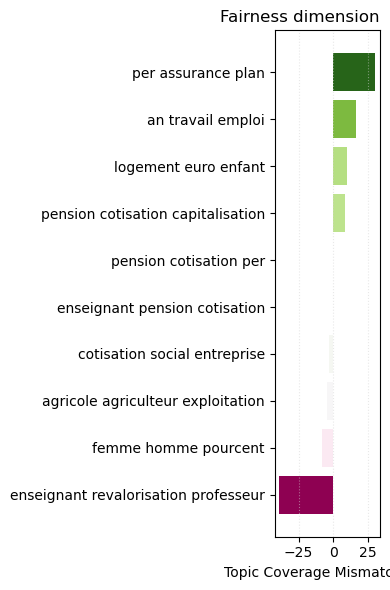

In [640]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Fairness dimension', loc='right')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Risk & Time

#### Matrices prep

In [641]:
documents = corpus_risktime_parl.to_list() + corpus_risktime_media.to_list()

In [642]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

num_rows_parl = len(corpus_economy_parl)
num_rows_media = len(corpus_economy_media)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:num_rows_parl, :]
count_matrix_media = count_matrix[-num_rows_media:, :]

In [643]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

#### CMF

In [644]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [645]:
cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

#### Results

In [646]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: travail, emploi, an, cotisation, social, entreprise, senior, vie, salaire, temps
Topic #2: per, assurance, contrat, plan, rente, revenu, assureur, versement, capital, retraire
Topic #3: agricole, agriculteur, exploitation, agriculture, terre, ferme, alimentaire, vache, foncier, paysan
Topic #4: professionnel, maladie, soin, assurance, patient, compte, social, pénibilité, charge, travail
Topic #5: enfant, famille, parent, familial, naissance, population, chinois, chine, an, alimentaire
Topic #6: femme, homme, pourcent, couple, conjoint, patrimoine, revenu, pension, argent, salarial
Topic #7: recherche, scientifique, chercheur, france, laboratoire, cancer, université, international, français, public
Topic #8: milliard, dette, pourcent, public, euro, pays, financier, banque, inflation, hausse
Topic #9: logement, immobilier, promoteur, scpi, 000, ville, neuf, loyer, prix, foncier
Topic #10: pension, capitalisation, cotisation, actif, fonds, fonctionnaire, retraire, niveau, pource

In [647]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [648]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

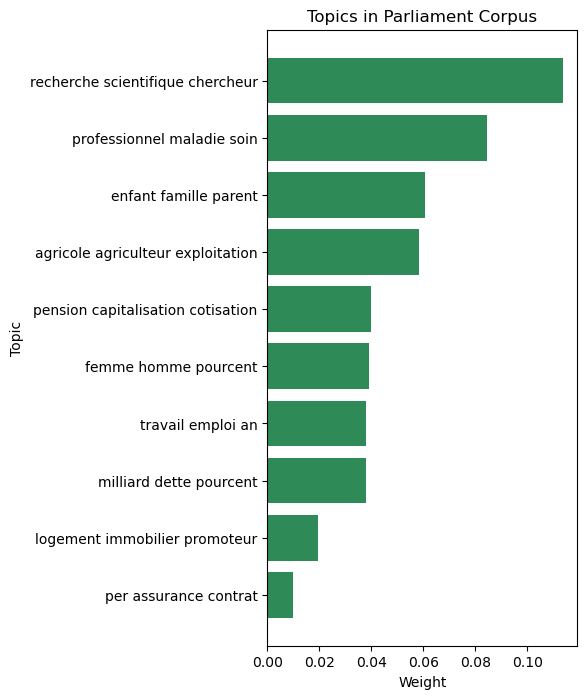

In [649]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='seagreen')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

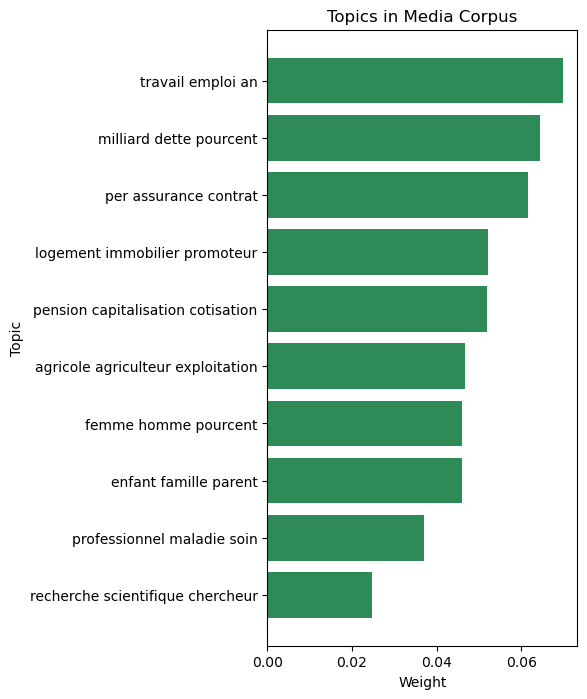

In [650]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='seagreen')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

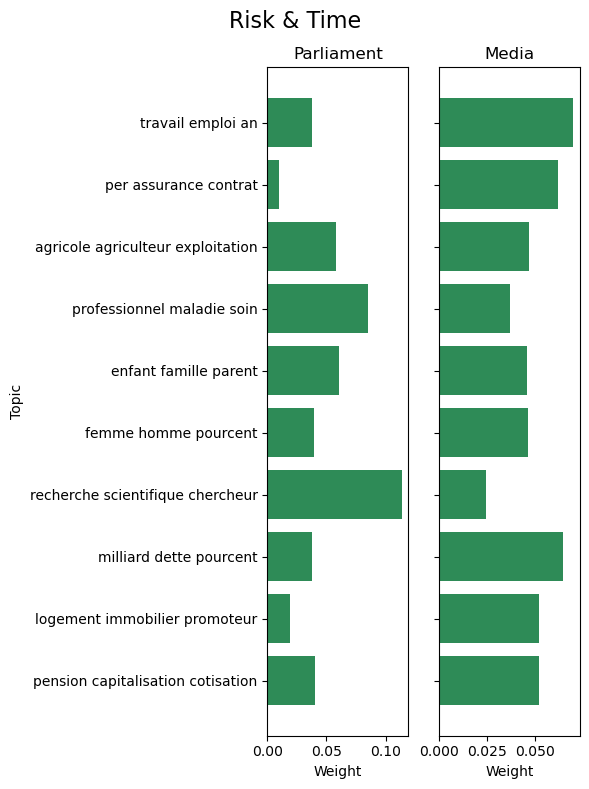

In [651]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='seagreen')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='seagreen')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Title
fig.suptitle('Risk & Time', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

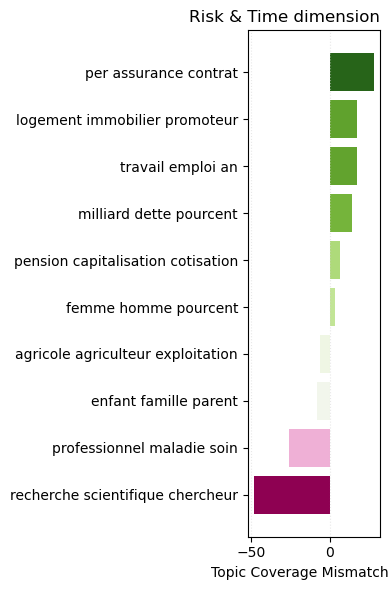

In [652]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Risk & Time dimension', loc='right')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Process

#### Matrices prep

In [653]:
documents = corpus_process_parl.to_list() + corpus_process_media.to_list()

In [654]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

num_rows_parl = len(corpus_economy_parl)
num_rows_media = len(corpus_economy_media)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:num_rows_parl, :]
count_matrix_media = count_matrix[-num_rows_media:, :]

In [655]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

#### CMF

In [656]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [657]:
cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

#### Results

In [658]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: syndicat, cgt, intersyndicale, cfdt, berger, laurent, mobilisation, manifestation, macron, organisation
Topic #2: amendement, lfi, article, rn, insoumis, dussopt, obstruction, gauche, examen, texte
Topic #3: banc, groupe, nupe, lfi, applaudissement, nupes, écolo, français, gdr, débat
Topic #4: gauche, gouvernement, peuple, communiste, force, mouvement, nupes, fi, fabien, social
Topic #5: vote, texte, 49, gouvernement, lr, voter, ministre, droite, cmp, projet
Topic #6: conseil, constitutionnel, rip, sage, loi, promulguer, demande, valider, partager, initiative
Topic #7: proposition, liot, juin, groupe, loi, abrogation, abroger, commission, texte, 40
Topic #8: groupe, lfi, banc, motion, censure, nupes, nupe, vote, gouvernement, 49
Topic #9: ordre, rappel, pancarte, sanction, comportement, bureau, sanctionner, brandir, instance, marseillais
Topic #10: motion, censure, groupe, voter, gouvernement, borne, 49, national, rn, vote


In [659]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [660]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

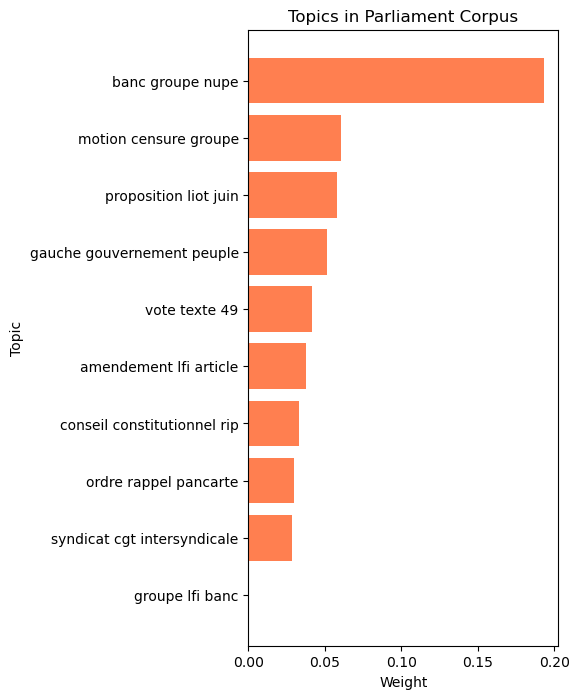

In [661]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='coral')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

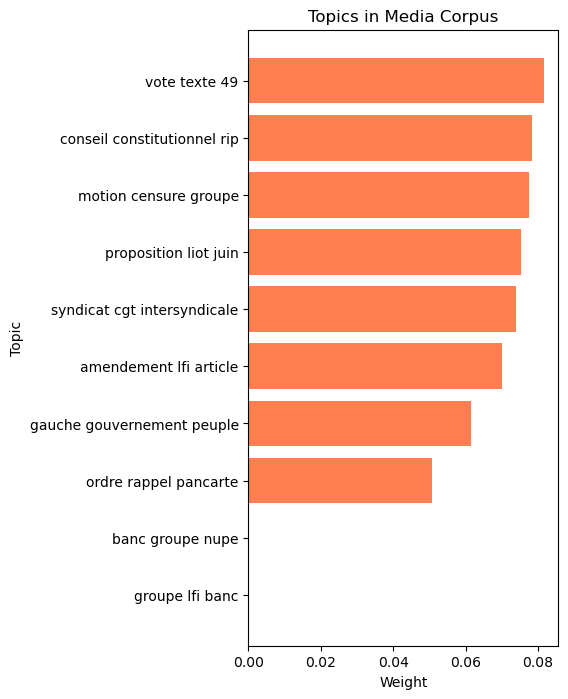

In [662]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(4, 8))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='coral')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

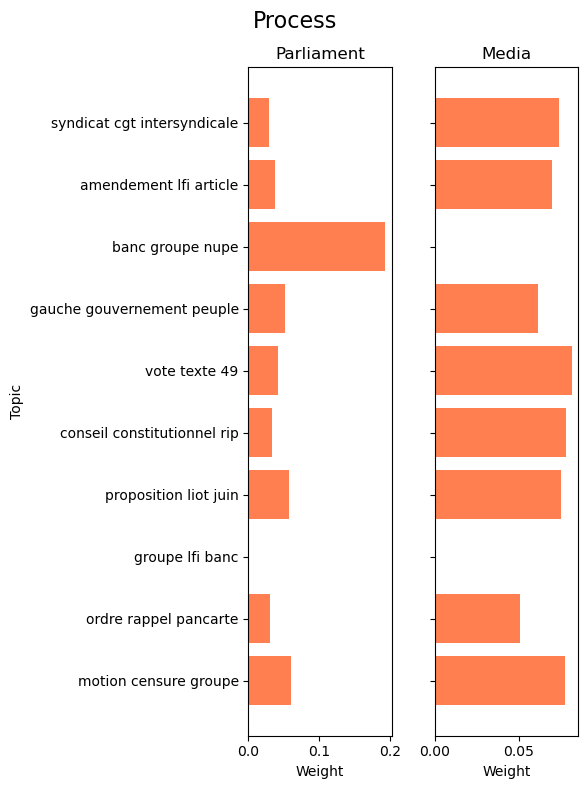

In [663]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='coral')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='coral')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Title
fig.suptitle('Process', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

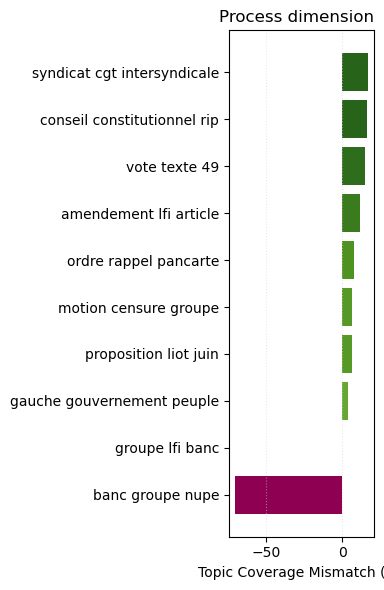

In [664]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Process dimension', loc='right')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges